In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt

import torch
import pytorch_lightning as pl

import warnings

from models import EfficientDetModel
from dataset import (
    CarsDatasetAdaptor,
    CarsDatasetAdaptorInference
)
from datamodules import EfficientDetDataModule
from utils import show_image_with_predict
from params import *

warnings.filterwarnings("ignore")

In [2]:
log_path = "../tb_logs"
project_name = "cars_detect"
version = "version_0"
ckpt_file = "cars-detector_epoch=19-valid_loss=1.3727.ckpt"
trained_ckpt_path = os.path.join(log_path, project_name, version,
                                 "checkpoints", ckpt_file)

In [3]:
torch.set_float32_matmul_precision("medium")

df = pd.read_csv(os.path.join(DATA_PATH, TRAIN_CSV))

model = EfficientDetModel.load_from_checkpoint(
    trained_ckpt_path,
    map_location="cuda",
    model_architecture=ARCHITECTURE
)

train_ds = CarsDatasetAdaptor(TRAIN_PATH, df)
valid_ds = CarsDatasetAdaptor(TRAIN_PATH, df)
predict_ds = CarsDatasetAdaptorInference(TEST_PATH)

dm = EfficientDetDataModule(
    train_dataset_adaptor=train_ds,
    validation_dataset_adaptor=valid_ds,
    predict_dataset_adaptor=predict_ds
)

trainer = pl.Trainer(
    accelerator="gpu",
    devices="auto",
    precision="16-mixed",
    max_epochs=20,
    )

{'name': 'tf_efficientnetv2_s', 'backbone_name': 'tf_efficientnetv2_s', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 1, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url': ''}

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Single sample

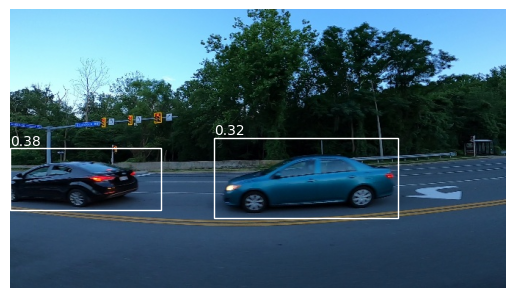

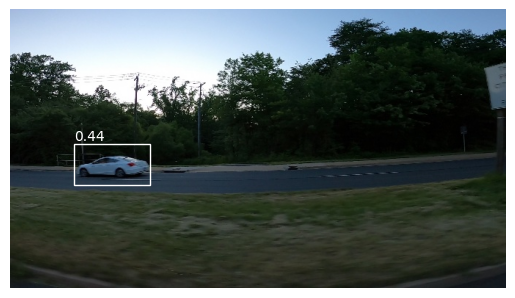

In [4]:
sample = plt.imread("../data/training_images/vid_4_720.jpg")
show_image_with_predict(model, sample)

sample = plt.imread("../data/testing_images/vid_5_26840.jpg")
show_image_with_predict(model, sample)

---

In [5]:
trainer.validate(model=model, datamodule=dm);

Missing logger folder: /home/rg_im/Documents/coding/pytorch/vision/efficientdet/code/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     mAP @[IoU=0.40]        0.9190201163291931
  valid_box_loss_epoch     0.0027622755151242018
 valid_class_loss_epoch      1.234564185142517
    valid_loss_epoch        1.3726781606674194
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [6]:
trainer.predict(model=model, datamodule=dm);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [7]:
result = model.predict_result
result.sample(5)

,image_id,box_coordinates,confidences
129,vid_5_30860.jpg,"[[216.53125, 187.7734375, 279.90625, 218.203125]]",[0.444091796875]
172,vid_5_30020.jpg,"[[0.0, 0.0, 0.0, 0.0]]",[0.0]
134,vid_5_30700.jpg,"[[0.0, 0.0, 0.0, 0.0]]",[0.0]
105,vid_5_29460.jpg,"[[361.765625, 184.8046875, 485.875, 230.078125]]",[0.533203125]
16,vid_5_30680.jpg,"[[0.0, 0.0, 0.0, 0.0]]",[0.0]
